In [60]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import itertools
import statsmodels.api as sm
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# I load the date set and fix the problem with missing Salaries for 59 players.
Hitter = pd.read_csv(r'C:\Users\panda\DecisionSupportSystems\Hitters.csv',index_col=0).dropna()
Hitter.index.name = 'Player'
Hitter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
AtBat        263 non-null int64
Hits         263 non-null int64
HmRun        263 non-null int64
Runs         263 non-null int64
RBI          263 non-null int64
Walks        263 non-null int64
Years        263 non-null int64
CAtBat       263 non-null int64
CHits        263 non-null int64
CHmRun       263 non-null int64
CRuns        263 non-null int64
CRBI         263 non-null int64
CWalks       263 non-null int64
League       263 non-null object
Division     263 non-null object
PutOuts      263 non-null int64
Assists      263 non-null int64
Errors       263 non-null int64
Salary       263 non-null float64
NewLeague    263 non-null object
dtypes: float64(1), int64(16), object(3)
memory usage: 43.1+ KB


#  6.5.1 Best Subset Selection

In [61]:
Hitter.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Player,,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [62]:
print("Check how many players have a null valeu at Salary:", Hitter["Salary"].isnull().sum())

Check how many players have a null valeu at Salary: 0


In [63]:
# Cleaning predictors up using Panda by genereting dummy variables, separate out the responses variable, and putting everything back together.
Hitter_dimmies = pd.get_dummies(Hitter[['League', 'Division', 'NewLeague']])

y = Hitter.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = Hitter.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set as X .
X = pd.concat([X_, Hitter_dimmies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

In [64]:
Hitter_dimmies.info()
print(Hitter_dimmies.head())

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 6 columns):
League_A       263 non-null uint8
League_N       263 non-null uint8
Division_E     263 non-null uint8
Division_W     263 non-null uint8
NewLeague_A    263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: uint8(6)
memory usage: 3.6+ KB
                   League_A  League_N  Division_E  Division_W  NewLeague_A  \
Player                                                                       
-Alan Ashby               0         1           0           1            0   
-Alvin Davis              1         0           0           1            1   
-Andre Dawson             0         1           1           0            0   
-Andres Galarraga         0         1           1           0            0   
-Alfredo Griffin          1         0           0           1            1   

                   NewLeague_N  
Player                          
-Alan Ashby             

In [69]:
# We preform best subset selection by identifying the best model with a given number of predictors. The book assignment used RSS and so will we. These are helper function to output best set of variabels.

def SubsetCalc(feature_set):
    # Fit model based on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [76]:
def getBestModel(k):
    
    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(SubsetCalc(combo))
    

    models = pd.DataFrame(results)
    
    # best model is the one with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]

    print("Processed", models.shape[0], "models on", k)
    
    # Return the best model
    return best_model

In [77]:
best_model = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in range(1,8):
    best_model.loc[i] = getBestModel(i)

toc = time.time()
print("Total time it took using basic subset:", (toc-tic), "seconds.")

Processed 19 models on 1
Processed 171 models on 2
Processed 969 models on 3
Processed 3876 models on 4
Processed 11628 models on 5
Processed 27132 models on 6
Processed 50388 models on 7
Total time it took using basic subset: 235.86595368385315 seconds.


In [78]:
#Details about our best model ( only containing Hits and CRBI)
best_model
print(best_model.loc[2,"model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.761
Model:                            OLS   Adj. R-squared (uncentered):              0.760
Method:                 Least Squares   F-statistic:                              416.7
Date:                Thu, 02 Apr 2020   Prob (F-statistic):                    5.80e-82
Time:                        11:36:17   Log-Likelihood:                         -1907.6
No. Observations:                 263   AIC:                                      3819.
Df Residuals:                     261   BIC:                                      3826.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [80]:
# Getting best model for 19 variables
print(getBestModel(19)["model"].summary())

Processed 1 models on 19
                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.810
Model:                            OLS   Adj. R-squared (uncentered):              0.795
Method:                 Least Squares   F-statistic:                              54.64
Date:                Thu, 02 Apr 2020   Prob (F-statistic):                    1.31e-76
Time:                        13:44:49   Log-Likelihood:                         -1877.9
No. Observations:                 263   AIC:                                      3794.
Df Residuals:                     244   BIC:                                      3862.
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
---------------

In [81]:
best_model.loc[2, "model"].rsquared

0.7614950002332872

In [82]:
# Showing R2 value. And as we can see our accouraty is increasing with more variables!. 
best_model.apply(lambda row: row[1].rsquared, axis=1)

1    0.664637
2    0.761495
3    0.771757
4    0.782885
5    0.789008
6    0.795140
7    0.797728
dtype: float64

Text(0, 0.5, 'BIC value')

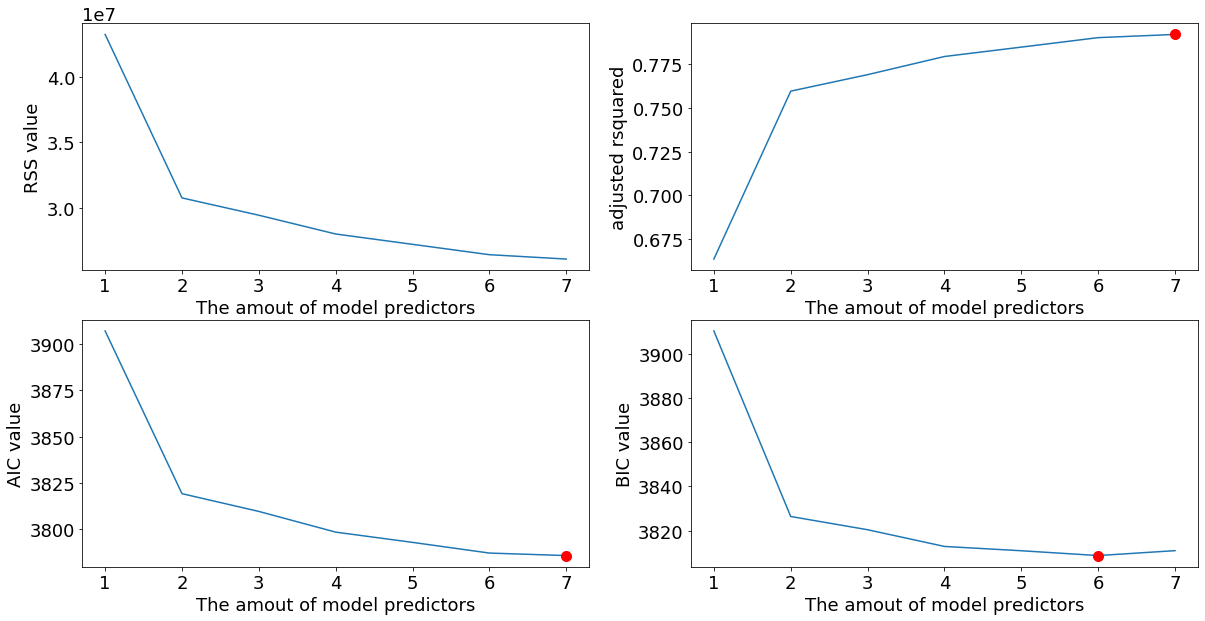

In [83]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

plt.subplot(2, 2, 1)

# Plotting red dot to indicate the model with the higest R2 stats.
plt.plot(best_model["RSS"])
plt.xlabel('The amout of model predictors')
plt.ylabel('RSS value')

rsquared_adj = best_model.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('The amout of model predictors')
plt.ylabel('adjusted rsquared')

# Smallest R2 for AIC and BIC
aic = best_model.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('The amout of model predictors')
plt.ylabel('AIC value')

bic = best_model.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('The amout of model predictors')
plt.ylabel('BIC value')

6.5.2

# 6.5.2 Forward and Backward Stepwise Selection

In [85]:
def forward_subset(predictors):

    # Extract predicators to processes
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    
    found_results = []
    
    for p in remaining_predictors:
        found_results.append(SubsetCalc(predictors+[p]))

        
    forward_models = pd.DataFrame(found_results)
    
    # Choose the model the best model based on highest RSS value
    best_model = forward_models.loc[forward_models['RSS'].argmin()]
    
    print("Processed ", forward_models.shape[0], "models on this amount of predicotrs:", len(predictors)+1)
    
      # Return the best found model
    return best_model

In [86]:
models_fwd = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
predictors = []

for i in range(1,len(X.columns)+1):    
    models_fwd.loc[i] = forward_subset(predictors)
    predictors = models_fwd.loc[i]["model"].model.exog_names

toc = time.time()
print("Total time it took using forward subset:", (toc-tic), "seconds.")

Processed  19 models on this amount of predicotrs: 1
Processed  18 models on this amount of predicotrs: 2
Processed  17 models on this amount of predicotrs: 3
Processed  16 models on this amount of predicotrs: 4
Processed  15 models on this amount of predicotrs: 5
Processed  14 models on this amount of predicotrs: 6
Processed  13 models on this amount of predicotrs: 7
Processed  12 models on this amount of predicotrs: 8
Processed  11 models on this amount of predicotrs: 9
Processed  10 models on this amount of predicotrs: 10
Processed  9 models on this amount of predicotrs: 11
Processed  8 models on this amount of predicotrs: 12
Processed  7 models on this amount of predicotrs: 13
Processed  6 models on this amount of predicotrs: 14
Processed  5 models on this amount of predicotrs: 15
Processed  4 models on this amount of predicotrs: 16
Processed  3 models on this amount of predicotrs: 17
Processed  2 models on this amount of predicotrs: 18
Processed  1 models on this amount of predico

In [87]:
# For this data, the best one-variable through six-variable models is identical for best subset and forward selection.
print(best_model.loc[6, "model"].summary())
print(models_fwd.loc[6, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.795
Model:                            OLS   Adj. R-squared (uncentered):              0.790
Method:                 Least Squares   F-statistic:                              166.3
Date:                Thu, 02 Apr 2020   Prob (F-statistic):                    1.79e-85
Time:                        13:44:55   Log-Likelihood:                         -1887.6
No. Observations:                 263   AIC:                                      3787.
Df Residuals:                     257   BIC:                                      3809.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [90]:
# backward is done looping through the predictors in reverse!
def backward_subset(predictors):
    
    found_results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        found_results.append(SubsetCalc(combo))
    
    backwards_models = pd.DataFrame(found_results)
    
    # Choose the model the best model based on highest RSS value
    best_model = backwards_models.loc[backwards_models['RSS'].argmin()]
    
    print("Processed ", backwards_models.shape[0], "models on this amount of predicotrs:", len(predictors)+1)
    # Return the best model found. 
    return best_model

In [91]:
models_bwd = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X.columns)))

tic = time.time()
predictors = X.columns

while(len(predictors) > 1):  
    models_bwd.loc[len(predictors)-1] = backward_subset(predictors)
    predictors = models_bwd.loc[len(predictors)-1]["model"].model.exog_names

toc = time.time()
print("Total time it took using backward subset:", (toc-tic), "seconds.")

Processed  19 models on this amount of predicotrs: 20
Processed  18 models on this amount of predicotrs: 19
Processed  17 models on this amount of predicotrs: 18
Processed  16 models on this amount of predicotrs: 17
Processed  15 models on this amount of predicotrs: 16
Processed  14 models on this amount of predicotrs: 15
Processed  13 models on this amount of predicotrs: 14
Processed  12 models on this amount of predicotrs: 13
Processed  11 models on this amount of predicotrs: 12
Processed  10 models on this amount of predicotrs: 11
Processed  9 models on this amount of predicotrs: 10
Processed  8 models on this amount of predicotrs: 9
Processed  7 models on this amount of predicotrs: 8
Processed  6 models on this amount of predicotrs: 7
Processed  5 models on this amount of predicotrs: 6
Processed  4 models on this amount of predicotrs: 5
Processed  3 models on this amount of predicotrs: 4
Processed  2 models on this amount of predicotrs: 3
Total time it took using backward subset: 0

In [ ]:
# For this data, the best one-variable through six-variable models is identical for best subset, forward and backward selection.

In [92]:
print("------------")
print("Best Subset:")
print("------------")
print(models_best.loc[7, "model"].params)

------------
Best Subset:
------------
Hits            1.680029
Walks           3.399961
CAtBat         -0.328835
CHits           1.347017
CHmRun          1.349373
PutOuts         0.248166
Division_W   -111.943760
dtype: float64


In [93]:
print("-----------------")
print("Foward Selection:")
print("-----------------")
print(models_fwd.loc[7, "model"].params)

-----------------
Foward Selection:
-----------------
Hits            7.277149
CRBI            0.652415
Division_W   -110.656338
PutOuts         0.259787
AtBat          -1.644651
Walks           3.684324
League_N       49.978410
dtype: float64


In [94]:
print("-------------------")
print("Backward Selection:")
print("-------------------")
print(models_bwd.loc[7, "model"].params)

-------------------
Backward Selection:
-------------------
AtBat         -1.601655
Hits           6.148449
Walks          5.866033
CRuns          1.097453
CWalks        -0.650614
PutOuts        0.310125
Division_W   -95.027171
dtype: float64
